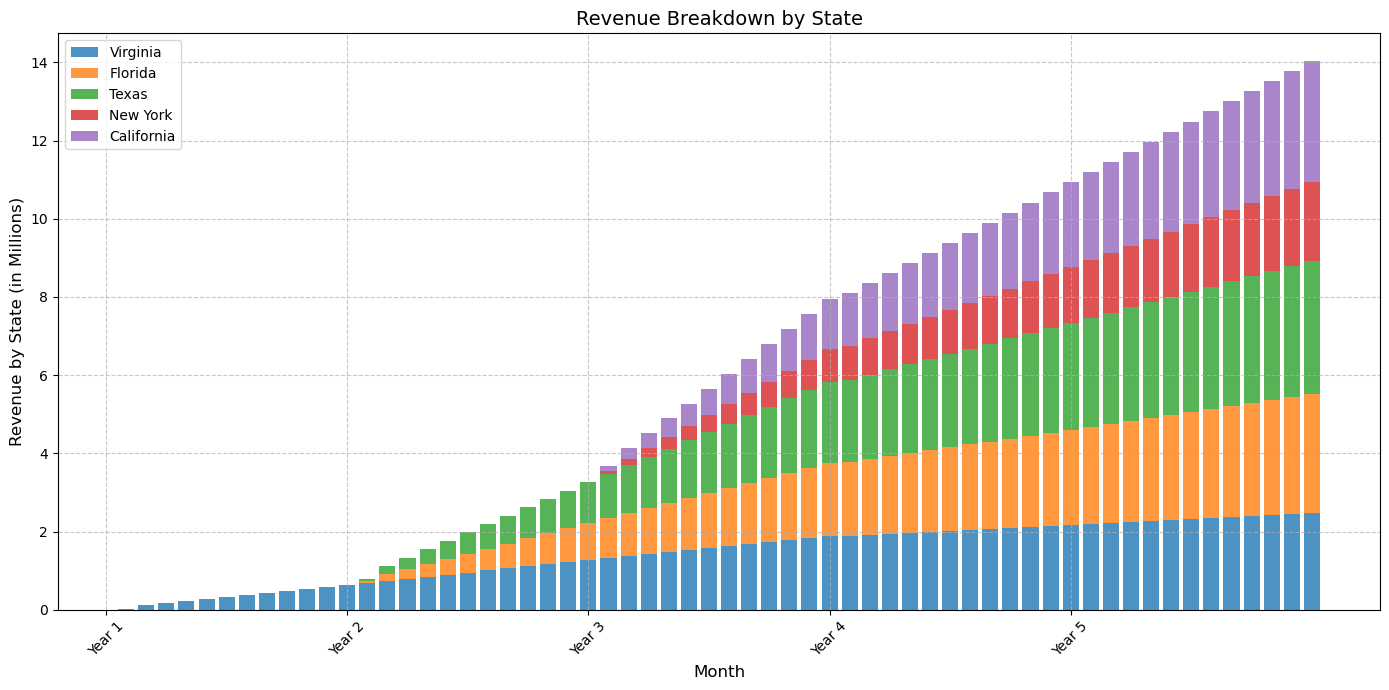

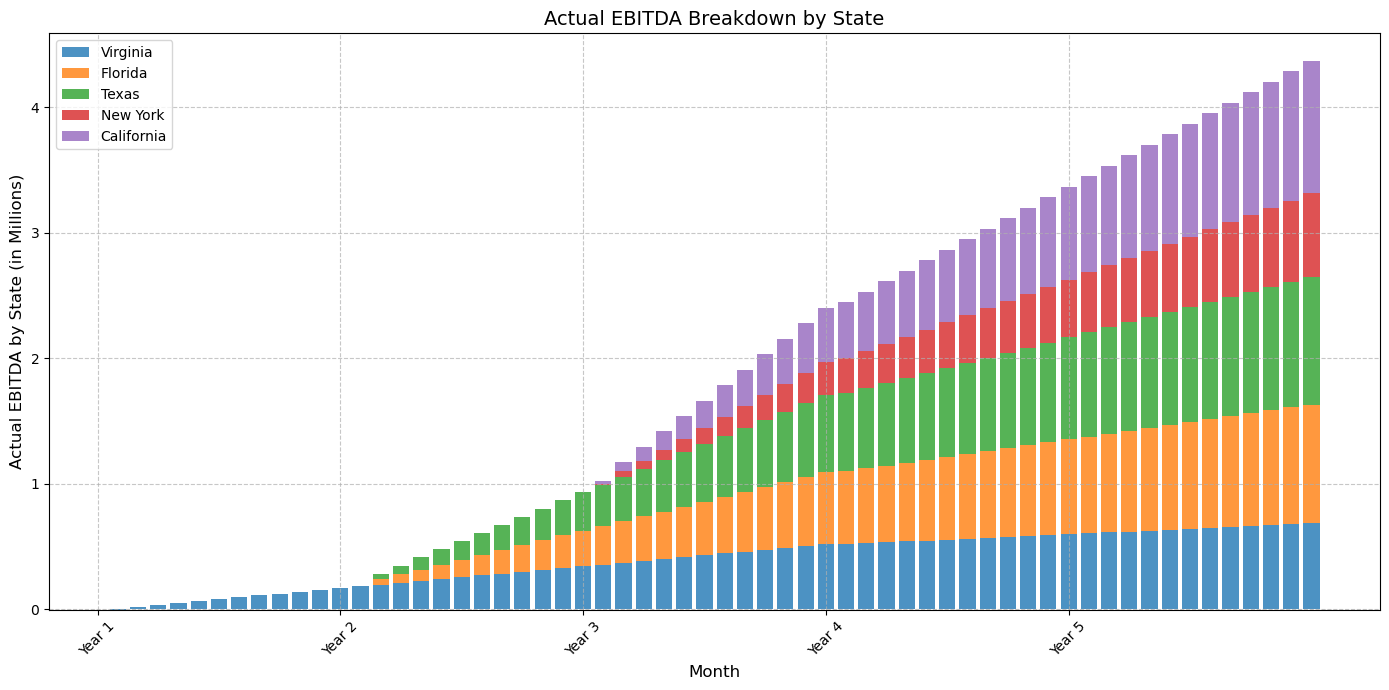

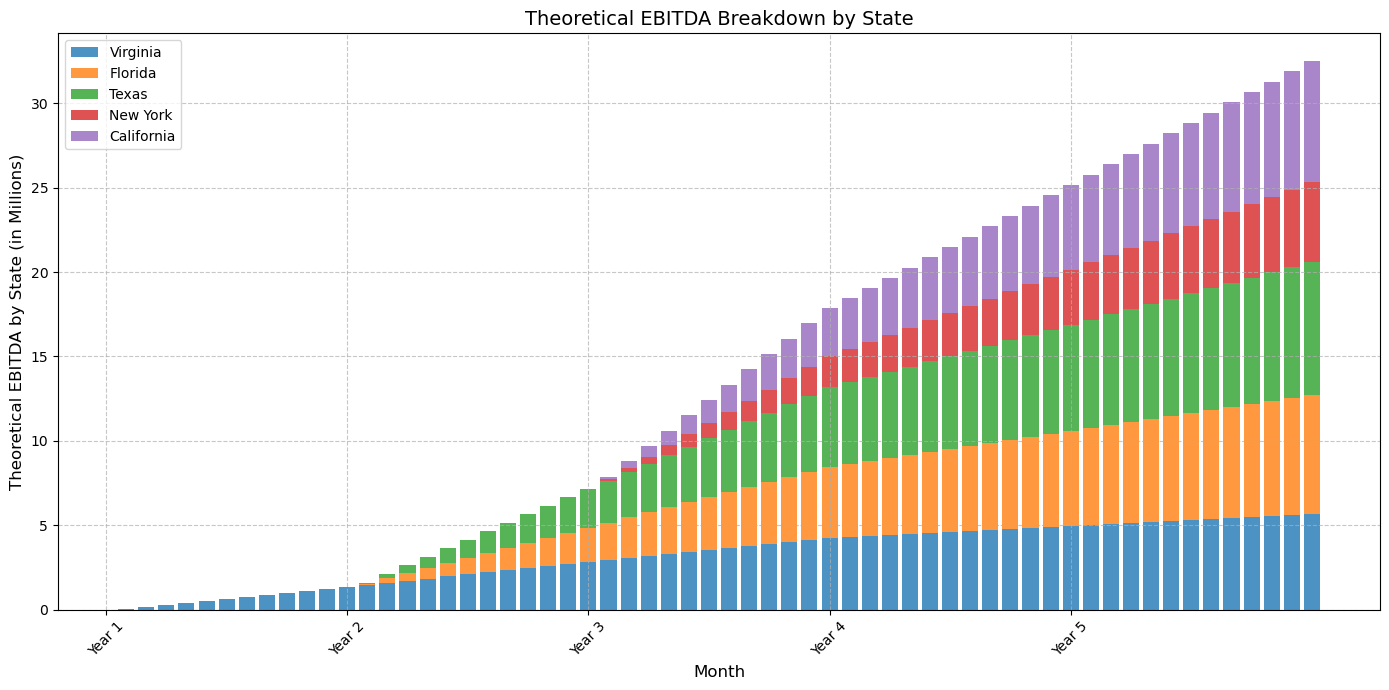

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants and initial parameters
states = ["Virginia", "Florida", "Texas", "New York", "California"]
gpci_adjustments = {"Virginia": 1.0, "Florida": 1.05, "Texas": 1.03, "New York": 1.08, "California": 1.1}
market_size_per_state = {"Virginia": 50000, "Florida": 70000, "Texas": 80000, "New York": 60000, "California": 90000}
nursing_homes_per_state = {"Virginia": 40, "Florida": 50, "Texas": 60, "New York": 30, "California": 70}
home_growth_rate = 0.05  # 5% annual growth in nursing homes
patients_per_home = 20  # Initial patients per nursing home
initial_cash = 1_500_000 - sum([500_000, 400_000, 300_000, 300_000])  # Remaining budget after initial spend
months = 60  # Simulation time in months

# Revenue and cost definitions
recurring_revenue_per_patient = {
    "99454": 45.12,
    "99457": 46.85,
    "99458": 37.62,
    "99490": 59.90,
    "99491": 80.98 / 20,
    "99091": 51.29,
}
non_recurring_revenue_per_patient = {"99453": 18.95, "TCM": 230.00}
theoretical_billing_codes = {
    "Alzheimer's Monitoring": 180.00,
    "Mental Health Support": 120.00,
    "Preventive Care": 200.00,
}
staffing_cost_per_patient = 50.00
platform_fee_per_patient = 5.00
hardware_cost_per_patient = 185.00
nurse_cost = 70_000 / 12 / 50
md_cost = 120_000 / 12 / (50 * 50)
operational_overhead_base = 10_000

# Initial state-specific onboarding numbers for the first month
initial_patients_by_state = {"Virginia": 50, "Florida": 100, "Texas": 100, "New York": 150, "California": 200}

# Data storage for results
data = {key: [] for key in ["Month", "State", "New Patients", "Total Patients",
                            "Market Penetration (%)", "Recurring Revenue",
                            "Non-Recurring Revenue", "Theoretical Revenue",
                            "Total Revenue", "Recurring Costs", "Non-Recurring Costs",
                            "Total Costs", "Actual EBITDA", "Theoretical EBITDA",
                            "Cash Balance"]}

# Helper function for monthly new patients
def calculate_monthly_new_patients(state, month, start_month, target_market_share, years_to_target, initial_patients):
    if month < start_month:
        return 0
    if month == start_month:
        return initial_patients
    months_to_target = years_to_target * 12 - (month - start_month)
    if months_to_target <= 0:
        return 0
    remaining_patients_to_target = target_market_share * market_size_per_state[state] - total_patients[state]
    monthly_growth = max(remaining_patients_to_target / months_to_target, 0)
    return int(monthly_growth)

# Simulation
total_patients = {state: 0 for state in states}
cash_balance = initial_cash

for month in range(1, months + 1):
    active_states = [state for state, start_month in start_month_for_state.items() if month >= start_month]
    for state in active_states:
        gpci = gpci_adjustments[state]
        nursing_homes = nursing_homes_per_state[state] * (1 + home_growth_rate) ** ((month - 1) // 12)
        max_patients = int(nursing_homes * patients_per_home)
        year = (month - 1) // 12 + 1
        years_to_target = 3 if year <= 3 else 5
        target_market_share = 0.15 if year <= 3 else 0.20
        new_patients = calculate_monthly_new_patients(
            state, month, start_month_for_state[state], target_market_share, years_to_target, initial_patients_by_state[state]
        )
        total_patients[state] += new_patients
        total_patients[state] = min(total_patients[state], market_size_per_state[state])
        recurring_revenue = sum(recurring_revenue_per_patient.values()) * gpci * total_patients[state]
        non_recurring_revenue = sum(non_recurring_revenue_per_patient.values()) * gpci * new_patients
        theoretical_revenue = sum(theoretical_billing_codes.values()) * gpci * total_patients[state]
        total_revenue = recurring_revenue + non_recurring_revenue
        recurring_cost = (staffing_cost_per_patient + platform_fee_per_patient) * total_patients[state]
        nurse_md_cost = (nurse_cost + md_cost) * total_patients[state]
        non_recurring_cost = hardware_cost_per_patient * new_patients
        operational_overhead = operational_overhead_base + len(active_states) * 1_000
        operational_overhead = min(operational_overhead, 50_000)
        total_costs = recurring_cost + nurse_md_cost + non_recurring_cost + operational_overhead
        actual_ebitda = total_revenue - total_costs
        theoretical_ebitda = total_revenue + theoretical_revenue - total_costs
        cash_balance += actual_ebitda
        data["Month"].append(month)
        data["State"].append(state)
        data["New Patients"].append(new_patients)
        data["Total Patients"].append(total_patients[state])
        data["Market Penetration (%)"].append((total_patients[state] / market_size_per_state[state]) * 100)
        data["Recurring Revenue"].append(recurring_revenue)
        data["Non-Recurring Revenue"].append(non_recurring_revenue)
        data["Theoretical Revenue"].append(theoretical_revenue)
        data["Total Revenue"].append(total_revenue)
        data["Recurring Costs"].append(recurring_cost)
        data["Non-Recurring Costs"].append(non_recurring_cost)
        data["Total Costs"].append(total_costs)
        data["Actual EBITDA"].append(actual_ebitda)
        data["Theoretical EBITDA"].append(theoretical_ebitda)
        data["Cash Balance"].append(cash_balance)



data["Year"] = [(month - 1) // 12 + 1 for month in data["Month"]]


financial_df = pd.DataFrame(data)

# Graphs
for metric, ylabel, title in [
    ("Total Revenue", "Revenue by State (in Millions)", "Revenue Breakdown by State"),
    ("Actual EBITDA", "Actual EBITDA by State (in Millions)", "Actual EBITDA Breakdown by State"),
    ("Theoretical EBITDA", "Theoretical EBITDA by State (in Millions)", "Theoretical EBITDA Breakdown by State"),
]:
    fig, ax = plt.subplots(figsize=(14, 7))
    grouped_data = financial_df.pivot_table(index="Month", columns="State", values=metric, aggfunc="sum").fillna(0)
    for state in states:
        ax.bar(
            grouped_data.index,
            grouped_data[state] / 1_000_000,
            label=f"{state}",
            bottom=grouped_data[states[:states.index(state)]].sum(axis=1) / 1_000_000 if states.index(state) > 0 else None,
            alpha=0.8,
        )
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="upper left", fontsize=10)
    ax.grid(visible=True, linestyle="--", alpha=0.7)
    xtick_locs = range(0, months + 1, 12)
    xtick_labels = [f"Year {i}" for i in range(1, len(xtick_locs))]
    ax.set_xticks(xtick_locs[:-1])
    ax.set_xticklabels(xtick_labels, rotation=45)
    plt.tight_layout()
    plt.show()


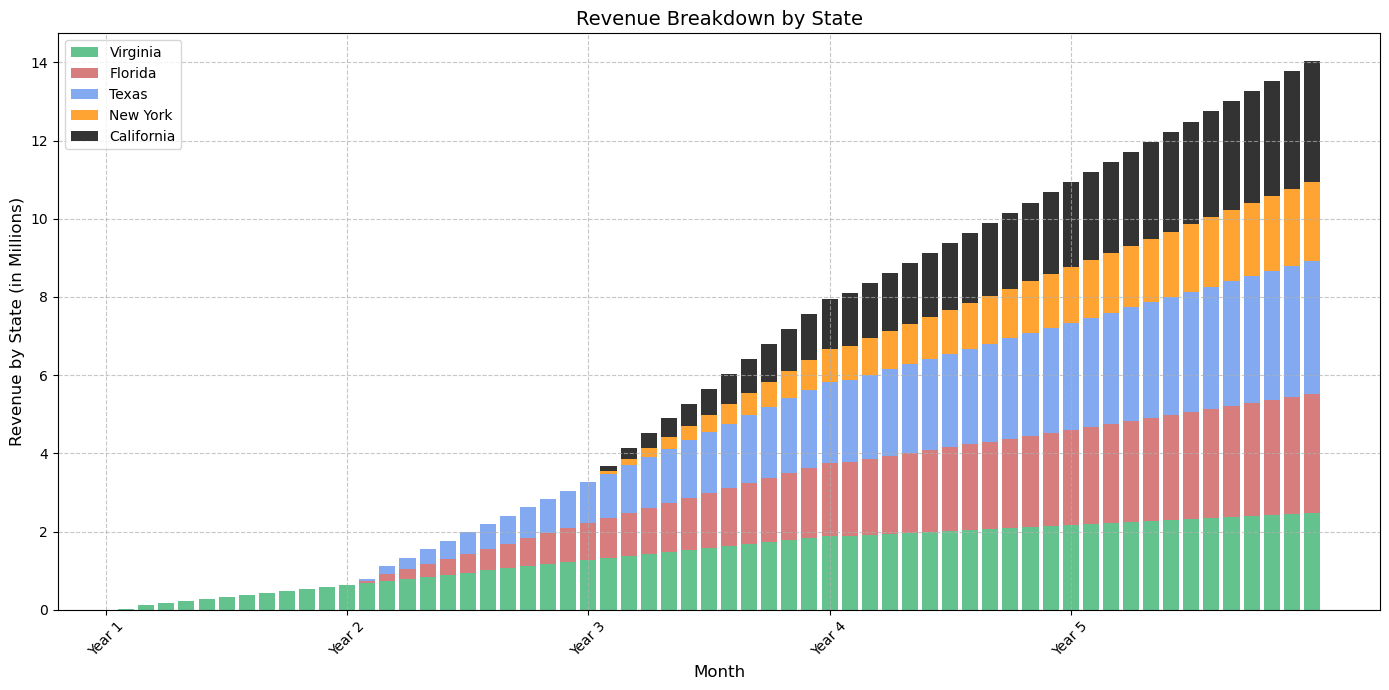

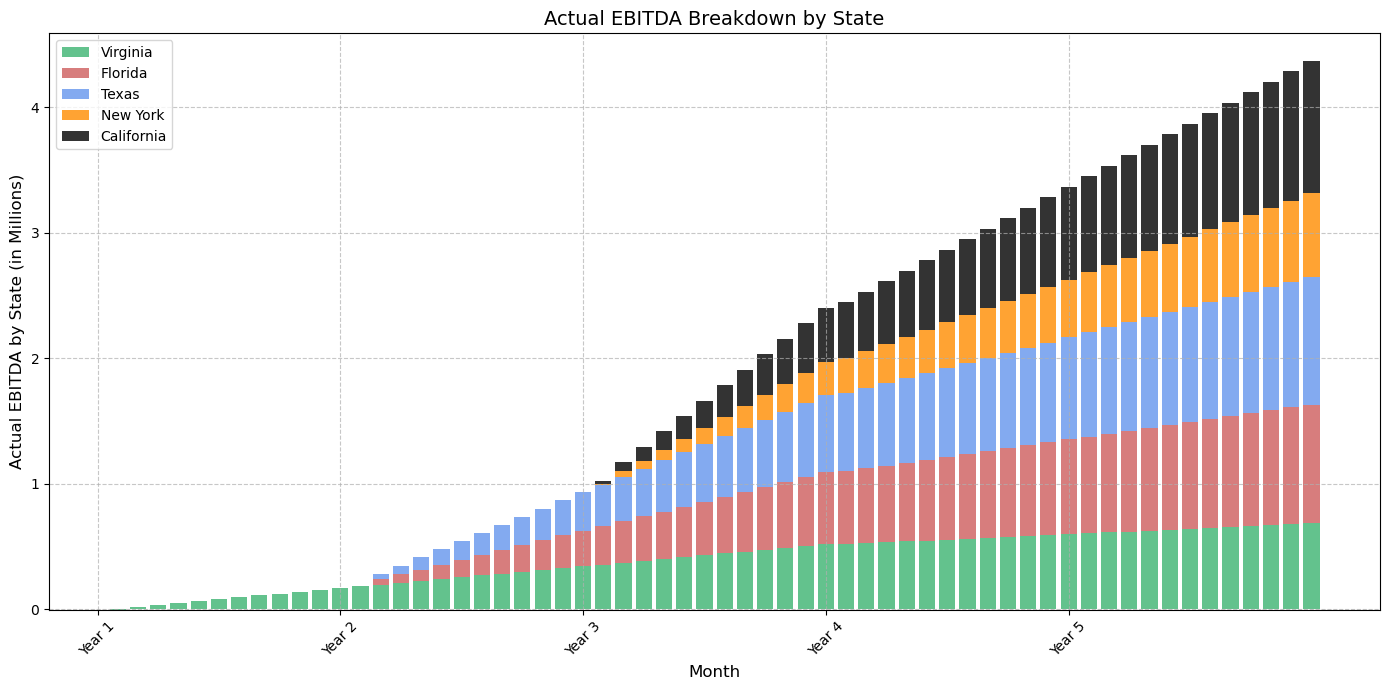

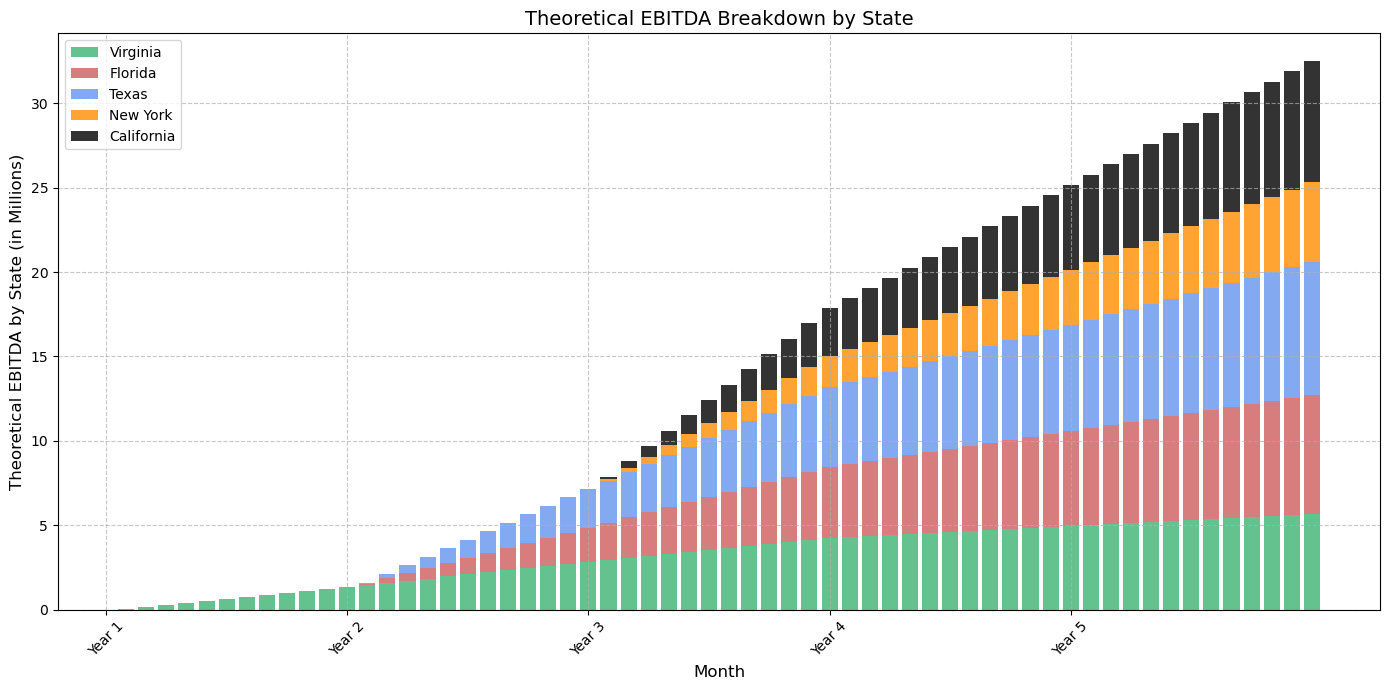

In [8]:
# Define a custom color palette
custom_colors = {
    "Virginia": "mediumseagreen",
    "Florida": "indianred",
    "Texas": "cornflowerblue",
    "New York": "darkorange",
    "California": "black",
}

# Update your graphing logic to apply these colors
for metric, ylabel, title in [
    ("Total Revenue", "Revenue by State (in Millions)", "Revenue Breakdown by State"),
    ("Actual EBITDA", "Actual EBITDA by State (in Millions)", "Actual EBITDA Breakdown by State"),
    ("Theoretical EBITDA", "Theoretical EBITDA by State (in Millions)", "Theoretical EBITDA Breakdown by State"),
]:
    fig, ax = plt.subplots(figsize=(14, 7))
    grouped_data = financial_df.pivot_table(index="Month", columns="State", values=metric, aggfunc="sum").fillna(0)
    bottom = np.zeros(len(grouped_data))
    for state in states:
        ax.bar(
            grouped_data.index,
            grouped_data[state] / 1_000_000,
            label=state,
            bottom=bottom,
            color=custom_colors[state],
            alpha=0.8,
        )
        bottom += grouped_data[state] / 1_000_000
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="upper left", fontsize=10)
    ax.grid(visible=True, linestyle="--", alpha=0.7)
    xtick_locs = range(0, months + 1, 12)
    xtick_labels = [f"Year {i}" for i in range(1, len(xtick_locs))]
    ax.set_xticks(xtick_locs[:-1])
    ax.set_xticklabels(xtick_labels, rotation=45)
    plt.tight_layout()
    plt.show()


In [33]:
grouped = financial_df.groupby(['Year','State'])[['Recurring Revenue','Non-Recurring Revenue', 'Actual EBITDA','Theoretical EBITDA']].sum().reset_index()

In [35]:
# Ensure the columns are numeric (convert if necessary)
columns_to_format = ['Recurring Revenue', 'Non-Recurring Revenue', 'Actual EBITDA','Theoretical EBITDA']
grouped[columns_to_format] = grouped[columns_to_format].apply(pd.to_numeric, errors='coerce')



In [36]:
# Define the columns to format
columns_to_format = ['Recurring Revenue', 'Non-Recurring Revenue', 'Actual EBITDA','Theoretical EBITDA']

# Apply formatting to each column
grouped[columns_to_format] = grouped[columns_to_format].apply(
    lambda row: row.apply(lambda x: "{:,.0f}".format(x) if pd.notnull(x) else ""), axis=1
)


In [38]:
grouped.to_clipboard()